In [1]:
## import lib
import pandas as pd
import numpy as np
from numpy.linalg import pinv,inv,matrix_power
from scipy.linalg import sqrtm
from scipy.io import loadmat
import itertools
import math
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# load data
data_dir = './Dataset/spam_data.mat'
data = loadmat(data_dir)
tr_data = data['train_x']
ts_data = data['test_x']
tr_label = data['train_y']
ts_label = data['test_y']

tr_N = tr_data.shape[0]
feat_dim = tr_data.shape[1]
ts_N = ts_data.shape[0]
print('tr_data-shape:',tr_data.shape)
print('ts_data-shape:',ts_data.shape)
print('tr_label-shape:',tr_label.shape)
print('ts_label-shape:',ts_label.shape)


tr_data-shape: (2000, 40)
ts_data-shape: (500, 40)
tr_label-shape: (2000, 2)
ts_label-shape: (500, 2)


In [3]:
cls1_index = tr_label[:,0]
cls2_index = tr_label[:,1]
cls1_posi = np.where(cls1_index==1)[0]
cls2_posi = np.where(cls2_index==1)[0]

## Structure : 40 - 10 - 3 - 2 
plot 3D figure

  0%|          | 0/800 [00:00<?, ?it/s]

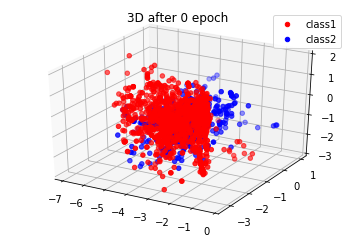

 25%|██▍       | 199/800 [00:06<00:20, 29.26it/s]

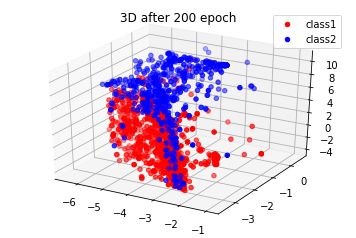

 50%|████▉     | 398/800 [00:14<00:14, 28.36it/s]

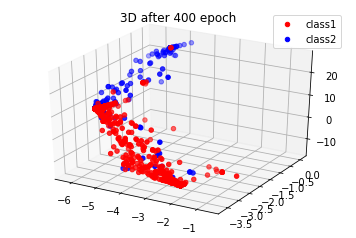

 70%|███████   | 562/800 [00:20<00:08, 27.72it/s]/Users/huitinghong/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
 75%|███████▌  | 600/800 [00:21<00:07, 27.52it/s]

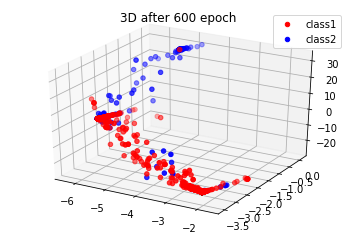

100%|██████████| 800/800 [00:28<00:00, 27.81it/s]


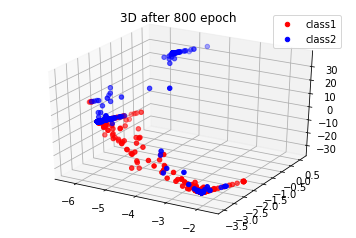

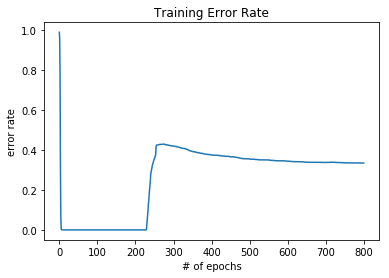

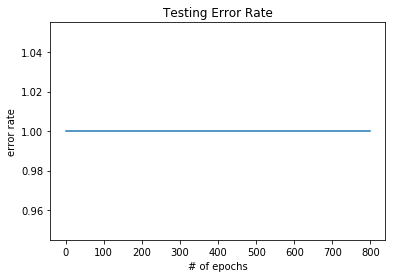

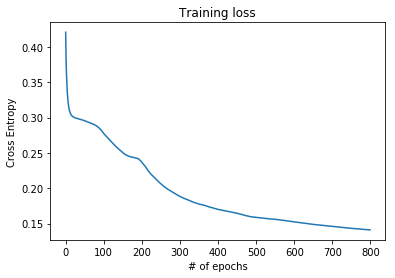

In [8]:
# Initial-Para.
W1 = np.random.randn(feat_dim, 10)
W2 = np.random.randn(10, 3)
W3 = np.random.randn(3, 2)
b1 = np.random.randn(10)
b2 = np.random.randn(3)
b3 = np.random.randn(2)
lr = 10e-5

def act_func(a_ary):
    # RELU
#     a_ary[a_ary<0]=0
#     return a_ary
    return np.divide(1,1+np.exp(-a_ary))

def act_derivative(a_ary):
    # Derivative of RELU
#     a_ary[a_ary<=0]=0
#     a_ary[a_ary>0]=1
#     return a_ary
    df_da = act_func(a_ary)*(act_func(-a_ary))
    return df_da
    
def self_softmax(a_ary):
    e_x = np.exp(a_ary - np.max(a_ary))
    return e_x / e_x.sum(axis=0)

# fwd, bwd
def fwd(input_X):
    trts_N = input_X.shape[0]
    b1_mat = np.tile(b1,(trts_N,1)).T
    b2_mat = np.tile(b2,(trts_N,1)).T
    b3_mat = np.tile(b3,(trts_N,1)).T    
    a1 = np.matmul(W1.T,input_X.T) + b1_mat
    h1 = act_func(a1)
    a2 = np.matmul(W2.T,h1) + b2_mat
    h2 = act_func(a2)
    a3 = np.matmul(W3.T,h2) + b3_mat
    y_pre = self_softmax(a3)
    return a1, a2, a3, h1, h2, y_pre
    
def bwd(x,h1,h2,y_pred,a1,a2,yt_label):
    global b1,b2,b3,W1,W2,W3
    
    g = y_pred - yt_label # the result of both derivative with y & softmac-function
    
    # third-layer
    grad_b3 = np.sum(g,axis = 1)
    grad_w3 = np.matmul(g,h2.T).T
    g = np.matmul(W3,g)
    
    # second-layer
    g = (a2>0)*g
    grad_b2 = np.sum(g,axis = 1)
    grad_w2 = np.matmul(g,h1.T).T
    g = np.matmul(W2,g)
    
    # first-layer
    g = (a1>0)*g
    grad_b1 = np.sum(g,axis = 1)
    grad_w1 = np.matmul(g,x).T
    
    grad_b = [grad_b1,grad_b2,grad_b3]
    grad_w = [grad_w1,grad_w2,grad_w3]
    return grad_b, grad_w

def Check_para():
    print(b1)
    print(b2)
    print(b3)
#     print(W1)
#     print(W2)
#     print(W3)
    
def Calculate_errRate(pred, gt):
    cnt = 0
    trts_N = pred.shape[1]
    for i in range(trts_N):
        y_pre = np.argmax(pred[:,i])
        y_gt = np.argmax(gt)
        if y_pre == y_gt:
            cnt += 1
    return 1 - cnt / tr_N
        
def plot3dResult(epo_th):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    b1_mat = np.tile(b1,(tr_N,1)).T
    b2_mat = np.tile(b2,(tr_N,1)).T
    b3_mat = np.tile(b3,(tr_N,1)).T    
    a1 = np.matmul(W1.T,tr_data.T) + b1_mat
    h1 = act_func(a1)
    a2 = np.matmul(W2.T,h1) + b2_mat
    h2 = act_func(a2)
    a3 = np.matmul(W3.T,h2) + b3_mat
    y_pre = self_softmax(a3)

    threed_scatter_pts = a2.T.tolist()
    threed_scatter_pts_cls1 = np.array([threed_scatter_pts[x][:] for x in cls1_posi])
    threed_scatter_pts_cls2 = np.array([threed_scatter_pts[x][:] for x in cls2_posi])
    cls1plt = ax.scatter(threed_scatter_pts_cls1[:,0], threed_scatter_pts_cls1[:,1], threed_scatter_pts_cls1[:,2], c='r', marker='o', label='class1')
    cls2plt = ax.scatter(threed_scatter_pts_cls2[:,0], threed_scatter_pts_cls2[:,1], threed_scatter_pts_cls2[:,2], c='b', marker='o', label='class2')
    plt.legend(handles=[cls1plt,cls2plt])
    plt.title('3D after %s epoch'%(str(epo_th)))
    plt.savefig('Classification_3dplot_epochN%s'%str(epo_th))
    plt.show()
    
# main-function
# Check_para()
ave_cross_entropy_loss_lst = []
err_rate_lst = []
err_rate_test_lst = []
epochN = 800
for i in tqdm(range(epochN)):
    a1, a2, a3, h1, h2, y_pred = fwd(tr_data)
    grad_b, grad_w = bwd(tr_data, h1, h2, y_pred, a1, a2, tr_label.T)
    ave_cross_entropy_loss = - np.mean(tr_label.T*np.log(y_pred))
    err_rate = Calculate_errRate(y_pred, tr_label.T)
    
    b1 -= lr*grad_b[0]
    b2 -= lr*grad_b[1]
    b3 -= lr*grad_b[2]
    W1 -= lr*grad_w[0]
    W2 -= lr*grad_w[1]
    W3 -= lr*grad_w[2]
#     rms_err_lst.append(rms_err)
    ave_cross_entropy_loss_lst.append(ave_cross_entropy_loss)
    err_rate_lst.append(err_rate)
    
    if i % 200 ==0:
        plot3dResult(i)
        
    ## Apply on Test Data
    a1_test, a2_test, a3_test, h1_test, h2_test, y_pred_test = fwd(ts_data)
    err_rate_test = Calculate_errRate(y_pred_test, ts_label.T)
    err_rate_test_lst.append(err_rate_test)
    
    
plot3dResult(epochN)
# print(rms_err)
plt.figure()
plt.title('Training Error Rate')
plt.xlabel('# of epochs')
plt.ylabel('error rate')
plt.plot(range(epochN), err_rate_lst)  
plt.savefig('Classification_Training_Err_rate_3D')

plt.figure()
plt.title('Testing Error Rate')
plt.xlabel('# of epochs')
plt.ylabel('error rate')
plt.plot(range(epochN), err_rate_test_lst)  
plt.savefig('Classification_Testing_Err_rate_3D')

plt.figure()
plt.title('Training loss')
plt.xlabel('# of epochs')
plt.ylabel('Cross Entropy')
plt.plot(range(epochN), ave_cross_entropy_loss_lst) 
plt.savefig('Classification_Train_loss_3D')

## Structure : 40 - 10 - 2 - 2
plot 2D figure

  0%|          | 0/800 [00:00<?, ?it/s]

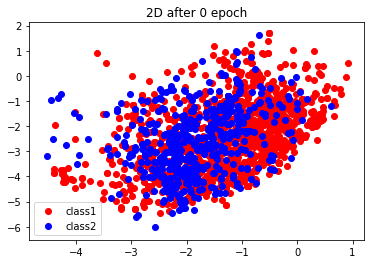

 25%|██▍       | 199/800 [00:06<00:18, 32.79it/s]

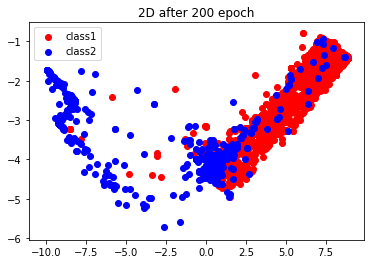

 46%|████▋     | 371/800 [00:11<00:12, 33.63it/s]/Users/huitinghong/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
 50%|████▉     | 396/800 [00:11<00:12, 33.64it/s]

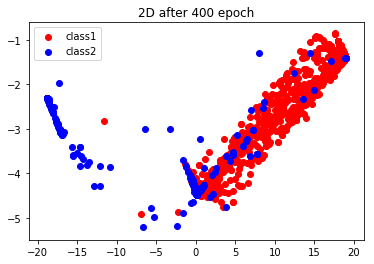

 75%|███████▍  | 599/800 [00:17<00:05, 33.97it/s]

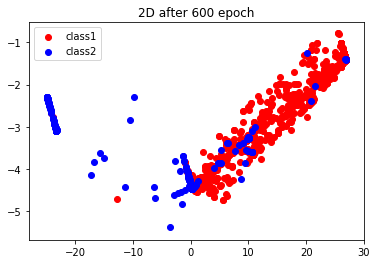

100%|██████████| 800/800 [00:22<00:00, 34.90it/s]


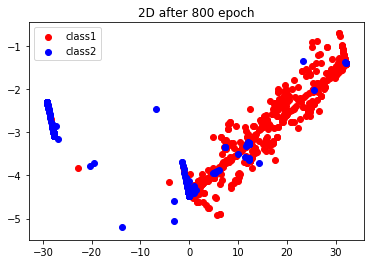

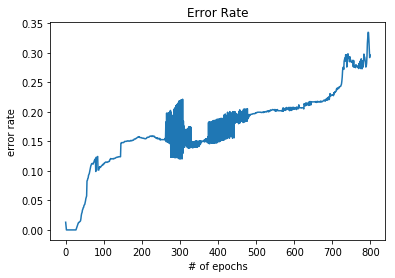

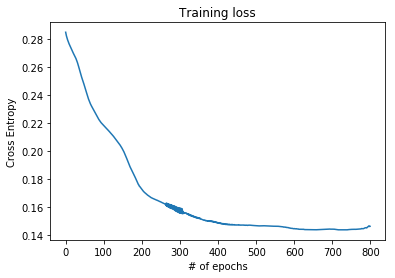

In [5]:
# Initial-Para.
W1 = np.random.randn(feat_dim, 10)
W2 = np.random.randn(10, 2)
W3 = np.random.randn(2, 2)
b1 = np.random.randn(10)
b2 = np.random.randn(2)
b3 = np.random.randn(2)
lr = 10e-5

def plot2dResult(epo_th):
    fig = plt.figure()
    
    b1_mat = np.tile(b1,(tr_N,1)).T
    b2_mat = np.tile(b2,(tr_N,1)).T
    b3_mat = np.tile(b3,(tr_N,1)).T    
    a1 = np.matmul(W1.T,tr_data.T) + b1_mat
    h1 = act_func(a1)
    a2 = np.matmul(W2.T,h1) + b2_mat
    h2 = act_func(a2)
    a3 = np.matmul(W3.T,h2) + b3_mat
    y_pre = self_softmax(a3)

    threed_scatter_pts = a2.T.tolist()
    threed_scatter_pts_cls1 = np.array([threed_scatter_pts[x][:] for x in cls1_posi])
    threed_scatter_pts_cls2 = np.array([threed_scatter_pts[x][:] for x in cls2_posi])
    cls1plt = plt.scatter(threed_scatter_pts_cls1[:,0], threed_scatter_pts_cls1[:,1],c='r', marker='o', label='class1')
    cls2plt = plt.scatter(threed_scatter_pts_cls2[:,0], threed_scatter_pts_cls2[:,1],c='b', marker='o', label='class2')
    plt.legend(handles=[cls1plt,cls2plt])
    plt.title('2D after %s epoch'%(str(epo_th)))
    plt.savefig('Classification_2dplot_epochN%s'%str(epo_th))
    plt.show()
    
# main-function
# Check_para()
rms_err_lst = []
ave_cross_entropy_loss_lst = []
err_rate_lst = []
epochN = 800
for i in tqdm(range(epochN)):
    a1, a2, a3, h1, h2, y_pred = fwd(tr_data)
    grad_b, grad_w = bwd(tr_data, h1, h2, y_pred, a1, a2, tr_label.T)
    ave_cross_entropy_loss = - np.mean(tr_label.T*np.log(y_pred))
    err_rate = Calculate_errRate(y_pred, tr_label.T)
    
    b1 -= lr*grad_b[0]
    b2 -= lr*grad_b[1]
    b3 -= lr*grad_b[2]
    W1 -= lr*grad_w[0]
    W2 -= lr*grad_w[1]
    W3 -= lr*grad_w[2]
#     rms_err_lst.append(rms_err)
    ave_cross_entropy_loss_lst.append(ave_cross_entropy_loss)
    err_rate_lst.append(err_rate)
    
    if i % 200 ==0:
        plot2dResult(i)
#     print(rms_err)

plot2dResult(epochN)
# print(rms_err)
plt.figure(1)
plt.title('Error Rate')
plt.xlabel('# of epochs')
plt.ylabel('error rate')
plt.plot(range(epochN), err_rate_lst)  
plt.savefig('Classification_Err_rate_2D')

plt.figure(2)
plt.title('Training loss')
plt.xlabel('# of epochs')
plt.ylabel('Cross Entropy')
plt.plot(range(epochN), ave_cross_entropy_loss_lst) 
plt.savefig('Classification_Train_loss_2D')

In [9]:
!jupyter nbconvert --to script Problem2_Classification.ipynb

[NbConvertApp] Converting notebook Problem2_Classification.ipynb to script
[NbConvertApp] Writing 7926 bytes to Problem2_Classification.py
